# PSF size for the different LSST filters

In [1]:
# Import general python packages
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas
from pandas.testing import assert_frame_equal
from astropy import units as u
from astropy.coordinates import SkyCoord


# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query

# Bokeh and holoviews for interactive visualization
import bokeh
from bokeh.io import output_file, output_notebook, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
import holoviews as hv

# To ignore some kinds of warnings
import warnings
from astropy.units import UnitsWarning

In [2]:
service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

In [3]:
coord = SkyCoord(ra=62.0*u.degree, dec=-37.0*u.degree, frame='icrs')
radius = 1 * u.deg

query = "SELECT obj.objectId, obj.ra, obj.dec, obj.mag_g, obj.mag_i, obj.mag_r, obj.mag_u, obj.mag_y, obj.mag_z, "\
        "obj.Ixx_pixel, obj.Ixx_pixel_g, obj.Ixx_pixel_i, obj.Ixx_pixel_r, obj.Ixx_pixel_u, "\
        "obj.Ixx_pixel_y, obj.Ixx_pixel_z, obj.IxxPSF_pixel, obj.IxxPSF_pixel_g, obj.IxxPSF_pixel_i, " \
        "obj.IxxPSF_pixel_r, obj.IxxPSF_pixel_u, obj.IxxPSF_pixel_y, obj.IxxPSF_pixel_z, obj.Ixy_pixel, "\
        "obj.Ixy_pixel_g, obj.Ixy_pixel_i, obj.Ixy_pixel_r, obj.Ixy_pixel_u, obj.Ixy_pixel_y, " \
        "obj.Ixy_pixel_z, obj.IxyPSF_pixel, obj.IxyPSF_pixel_g, obj.IxyPSF_pixel_i, " \
        "obj.IxyPSF_pixel_r, obj.IxyPSF_pixel_u, obj.IxyPSF_pixel_y, obj.IxyPSF_pixel_z, " \
        "obj.Iyy_pixel, obj.Iyy_pixel_g, obj.Iyy_pixel_i, obj.Iyy_pixel_r, obj.Iyy_pixel_u, " \
        "obj.Iyy_pixel_y, obj.Iyy_pixel_z, obj.IyyPSF_pixel, obj.IyyPSF_pixel_g, obj.IyyPSF_pixel_i, " \
        "obj.IyyPSF_pixel_r, obj.IyyPSF_pixel_u, obj.IyyPSF_pixel_y, obj.IyyPSF_pixel_z," \
        "obj.tract, obj.patch, " \
        "obj.extendedness, obj.good, obj.clean, " \
        "truth.mag_r as truth_mag_r, truth.match_objectId, "\
        "truth.flux_g, truth.flux_r, truth.flux_i, truth.truth_type, " \
        "truth.match_sep, truth.is_variable " \
        "FROM dp01_dc2_catalogs.object as obj " \
        "JOIN dp01_dc2_catalogs.truth_match as truth " \
        "ON truth.match_objectId = obj.objectId " \
        "WHERE CONTAINS(POINT('ICRS', obj.ra, obj.dec),CIRCLE('ICRS', " \
        + str(coord.ra.value) + ", " + str(coord.dec.value) + ", " \
        + str(radius.value) + " )) = 1 " \
        "AND truth.match_objectid >= 0 "\
        "AND obj.extendedness = 0 "\
        "AND truth.is_good_match = 1"

results = service.search(query).to_table().to_pandas()

In [4]:
#print(results.columns.tolist())
results.columns

Index(['objectId', 'ra', 'dec', 'mag_g', 'mag_i', 'mag_r', 'mag_u', 'mag_y',
       'mag_z', 'Ixx_pixel', 'Ixx_pixel_g', 'Ixx_pixel_i', 'Ixx_pixel_r',
       'Ixx_pixel_u', 'Ixx_pixel_y', 'Ixx_pixel_z', 'IxxPSF_pixel',
       'IxxPSF_pixel_g', 'IxxPSF_pixel_i', 'IxxPSF_pixel_r', 'IxxPSF_pixel_u',
       'IxxPSF_pixel_y', 'IxxPSF_pixel_z', 'Ixy_pixel', 'Ixy_pixel_g',
       'Ixy_pixel_i', 'Ixy_pixel_r', 'Ixy_pixel_u', 'Ixy_pixel_y',
       'Ixy_pixel_z', 'IxyPSF_pixel', 'IxyPSF_pixel_g', 'IxyPSF_pixel_i',
       'IxyPSF_pixel_r', 'IxyPSF_pixel_u', 'IxyPSF_pixel_y', 'IxyPSF_pixel_z',
       'Iyy_pixel', 'Iyy_pixel_g', 'Iyy_pixel_i', 'Iyy_pixel_r', 'Iyy_pixel_u',
       'Iyy_pixel_y', 'Iyy_pixel_z', 'IyyPSF_pixel', 'IyyPSF_pixel_g',
       'IyyPSF_pixel_i', 'IyyPSF_pixel_r', 'IyyPSF_pixel_u', 'IyyPSF_pixel_y',
       'IyyPSF_pixel_z', 'tract', 'patch', 'extendedness', 'good', 'clean',
       'truth_mag_r', 'match_objectId', 'flux_g', 'flux_r', 'flux_i',
       'truth_type', 'match_sep', '

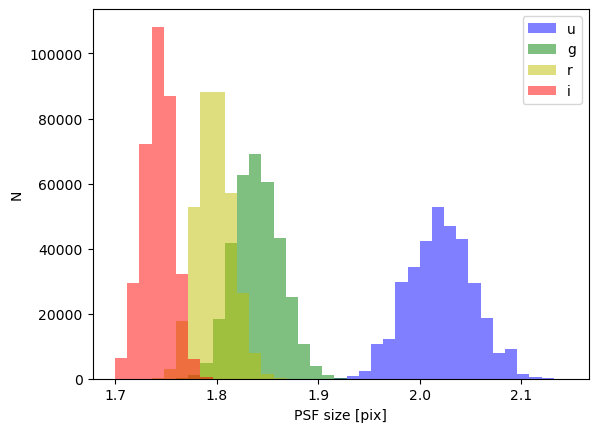

In [5]:
size_u = np.sqrt((results["IxxPSF_pixel_u"] + results["IyyPSF_pixel_u"]) / 2.)
size_g = np.sqrt((results["IxxPSF_pixel_g"] + results["IyyPSF_pixel_g"]) / 2.)
size_r = np.sqrt((results["IxxPSF_pixel_r"] + results["IyyPSF_pixel_r"]) / 2.)
size_i = np.sqrt((results["IxxPSF_pixel_i"] + results["IyyPSF_pixel_i"]) / 2.)
#size_z = np.sqrt((results["IxxPSF_pixel_z"] + results["IyyPSF_pixel_z"]) / 2.)
#size_y = np.sqrt((results["IxxPSF_pixel_y"] + results["IyyPSF_pixel_y"]) / 2.)
bins = np.arange(1.7, 2.15, 0.012)

plt.hist(size_u, bins, alpha=0.5, color = 'b', label='u')
plt.hist(size_g, bins, alpha=0.5, color = 'g', label='g')
plt.hist(size_r, bins, alpha=0.5, color = 'y', label='r')
plt.hist(size_i, bins, alpha=0.5, color = 'r', label='i')
#plt.hist(size_z, bins, alpha=0.5, label='z')
#plt.hist(size_y, bins, alpha=0.5, label='y')
plt.xlabel('PSF size [pix]')
plt.ylabel('N')

plt.legend()